In [2]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from copy import deepcopy
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import string
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from IPython.display import Latex
from keras.datasets import cifar10
import tensorflow as tf

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [3]:
seed = 99
np.random.seed(seed)
train_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
)
y_pytorch = train_set.targets

seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)
clean_data_size = 200

# Load the CIFAR10 data.
(x_train_, y_train_), (x_test, y_test) = cifar10.load_data()
y_keras = y_train_

Files already downloaded and verified


In [5]:
train_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomResizedCrop(32, scale=(0.64, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

valid_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    transform=train_transform,
    download=True,
)


valid_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    transform=valid_transform,
    download=True,
)

num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

y_train = np.array(train_set.targets[split:])
y_train_org = deepcopy(y_train)
# Generate clean dataset
clean_index = []
for i in range(10):
    positive_index = list(np.where(y_train == i)[0])
    clean_index = np.append(clean_index, np.random.choice(positive_index, 200, replace=False)).astype(int)

noisy_index = list(set(range(len(train_idx)))-set(clean_index))

Files already downloaded and verified
Files already downloaded and verified


In [24]:
file = open('additional_data_index2.txt')
lines = file.readlines()
precision = '['
for line in lines:
    precision += line.replace('\n', '').replace(' ', ',')
precision += ']'
precision = eval(
    precision.replace('][', '], [').replace(',,,,', ',').replace(',,,', ',').replace(',,', ',').replace('[,', '['))
noisy_index = np.array(noisy_index)
for label in range(10):
    index = precision[label]
    print(np.mean(y_train[noisy_index[index]] == label))

0.7918367346938775
0.818889970788705
0.8982142857142857
0.5402504472271914
0.7757142857142857
0.7311577311577312
0.7127363737486095
0.7459153051017006
0.9091386554621849
0.712697181277476


In [62]:
num = [len(x) for x in precision]
inter = [[len(set(x).intersection(set(y))) for x in precision] for y in precision]
print(num)
print(np.array(inter))

[1960, 3081, 560, 559, 700, 1287, 3596, 2999, 1904, 3867]
[[1960    3   16    2    0    0    0    2   62    5]
 [   3 3081    0    0    0    1    3    3   17  579]
 [  16    0  560    1    3    0   12    0    0    1]
 [   2    0    1  559    0  131   13    0    0    0]
 [   0    0    3    0  700    0   20   31    2    0]
 [   0    1    0  131    0 1287    8   32    0    0]
 [   0    3   12   13   20    8 3596   19    0   10]
 [   2    3    0    0   31   32   19 2999    0   21]
 [  62   17    0    0    2    0    0    0 1904    9]
 [   5  579    1    0    0    0   10   21    9 3867]]


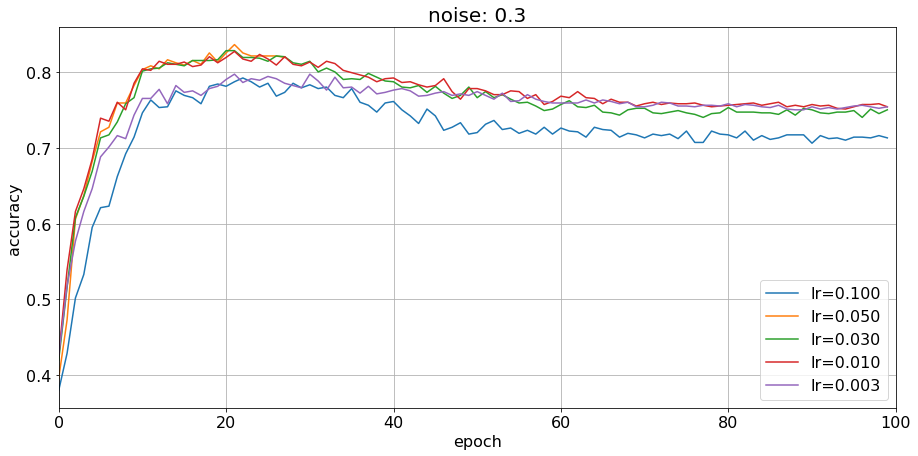

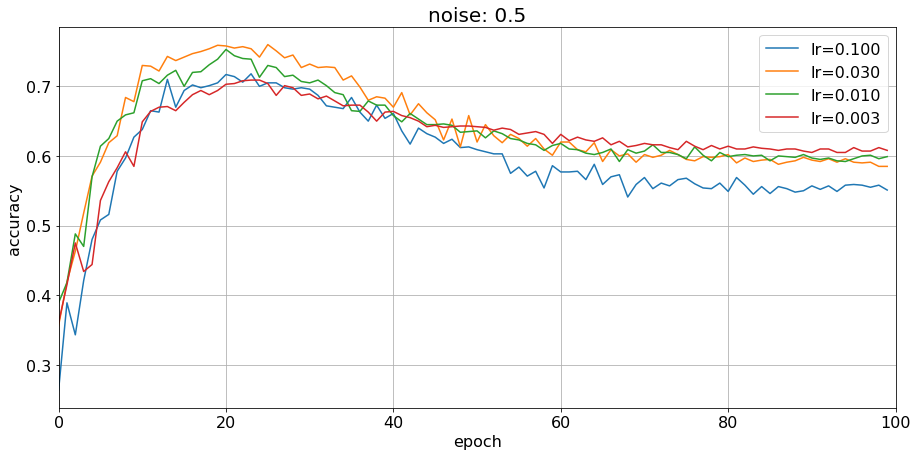

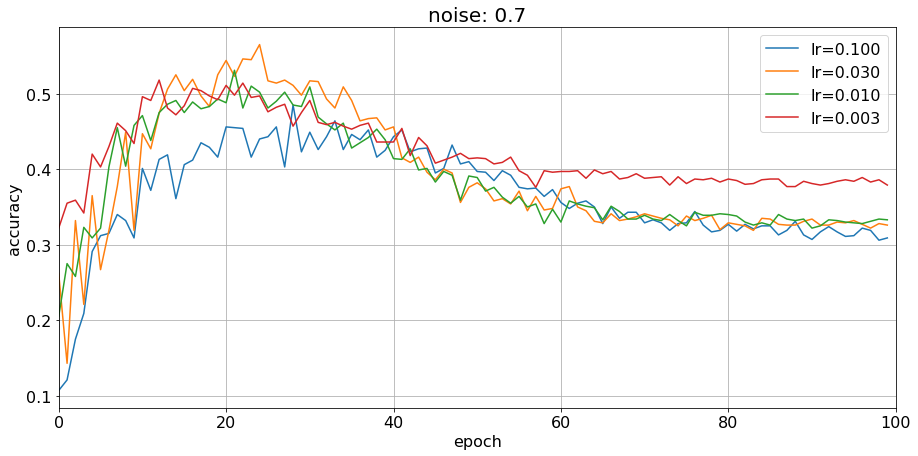

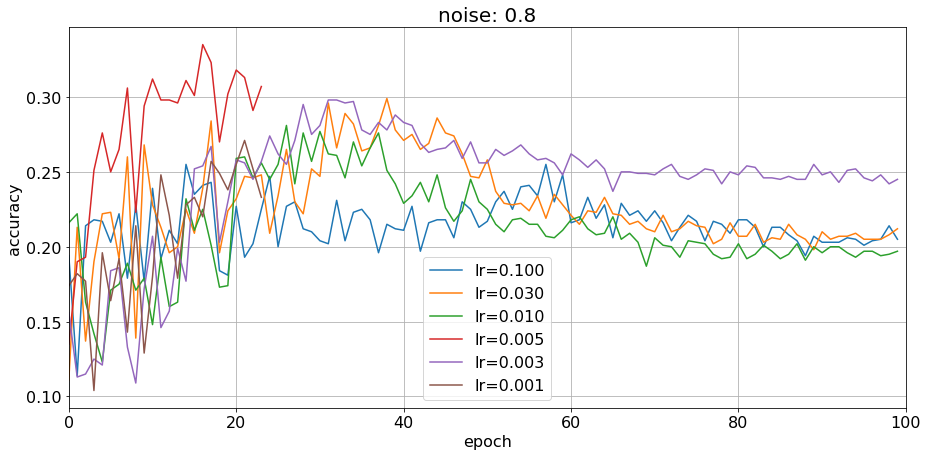

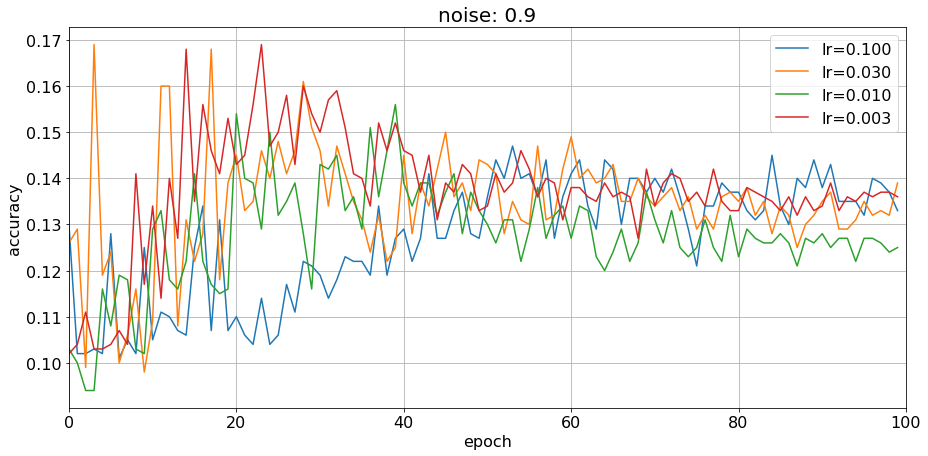

In [71]:
for noise in [0.3, 0.5, 0.7, 0.8, 0.9]:
    plt.figure(figsize=(15,7))
    
    for lr in ['0.100', '0.050', '0.030', '0.010', '0.005', '0.003', '0.001']:
        try:
            file = open('record/acc_lr_'+lr+'_noise_'+str(noise)+'.txt')
            lines = file.readlines()
            val_acc = []
            test_acc = []
            for line in lines:
                new_line = re.split(':|,| |\n', line.strip())
                val_acc.append(eval(new_line[12]))
                test_acc.append(eval(new_line[17]))                       
            plt.plot(val_acc, label='lr='+lr)
            
        except:
            pass
    plt.title('noise: '+str(noise), fontsize=20)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('epoch', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim([0,100])
    plt.grid()
    plt.legend(fontsize=16)
    plt.show()

In [75]:
table = PrettyTable([' ', 'Noise=0.3', '0.5', '0.7', '0.8', '0.9'])
for lr in ['0.100', '0.050', '0.030', '0.010', '0.005', '0.003', '0.001']:
    test = [lr]
    for noise in [0.3, 0.5, 0.7, 0.8, 0.9]:
        try:
            file = open('record/acc_lr_'+lr+'_noise_'+str(noise)+'.txt')
            lines = file.readlines()
            val_acc = []
            test_acc = []
            for line in lines:
                new_line = re.split(':|,| |\n', line.strip())
                val_acc.append(eval(new_line[12]))
                test_acc.append(eval(new_line[17]))   
            test.append(max(test_acc))
        except:
            test.append('/')
    table.add_row(test)
print(table)

+-------+-----------+-------+-------+-------+-------+
|       | Noise=0.3 |  0.5  |  0.7  |  0.8  |  0.9  |
+-------+-----------+-------+-------+-------+-------+
| 0.100 |   0.792   | 0.718 | 0.483 | 0.265 | 0.147 |
| 0.050 |   0.826   |   /   |   /   |   /   |   /   |
| 0.030 |   0.825   | 0.755 |  0.57 | 0.295 | 0.168 |
| 0.010 |   0.821   | 0.751 | 0.535 | 0.284 | 0.153 |
| 0.005 |     /     |   /   |   /   | 0.347 |   /   |
| 0.003 |   0.797   | 0.705 | 0.524 | 0.298 | 0.179 |
| 0.001 |     /     |   /   |   /   | 0.278 |   /   |
+-------+-----------+-------+-------+-------+-------+


In [78]:
table = PrettyTable([' ', 'Noise=0.3', '0.5', '0.7', '0.8', '0.9'])
for lr in ['0.100', '0.050', '0.030', '0.010', '0.005', '0.003', '0.001']:
    test = [lr]
    for noise in [0.3, 0.5, 0.7, 0.8, 0.9]:
        try:
            file = open('record/PreAct_Benchmark/acc_lr_'+lr+'_noise_'+str(noise)+'_0.txt')
            lines = file.readlines()
            val_acc = []
            test_acc = []
            for line in lines:
                new_line = re.split(':|,| |\n', line.strip())
                val_acc.append(eval(new_line[12]))
                test_acc.append(eval(new_line[17]))   
            test.append(max(test_acc))
        except:
            test.append('/')
    table.add_row(test)
print(table)

+-------+-----------+-------+-------+-------+-------+
|       | Noise=0.3 |  0.5  |  0.7  |  0.8  |  0.9  |
+-------+-----------+-------+-------+-------+-------+
| 0.100 |     /     |   /   |   /   |   /   |   /   |
| 0.050 |   0.805   | 0.745 | 0.561 |   /   |   /   |
| 0.030 |     /     |   /   |   /   |   /   |   /   |
| 0.010 |     /     |   /   |   /   |   /   |   /   |
| 0.005 |     /     |   /   |   /   | 0.396 | 0.211 |
| 0.003 |     /     |   /   |   /   |   /   |   /   |
| 0.001 |     /     |   /   |   /   |   /   |   /   |
+-------+-----------+-------+-------+-------+-------+
